In [9]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.0


In [10]:
data = np.random.normal(loc=0, scale=1, size=1000)

In [11]:
def normal_sim(rng, a, b, size=1000):
    return rng.normal(a, b, size=size)

In [15]:
with pm.Model() as example:
    a = pm.Normal("a", mu=0, sigma=5)
    b = pm.HalfNormal("b", sigma=1)
    s = pm.Simulator("s", normal_sim, params=(a, b), sum_stat="sort", epsilon=1, observed=data)

    idata = pm.sample_smc()
    idata.extend(pm.sample_posterior_predictive(idata))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [a]
>Slice: [b]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
Sampling: [s]


In [23]:
# print attributes of the InferenceData object
for item in idata:
    print(item)

posterior
posterior_predictive
sample_stats
observed_data


In [16]:
print(idata.posterior.draw.shape)

(500,)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

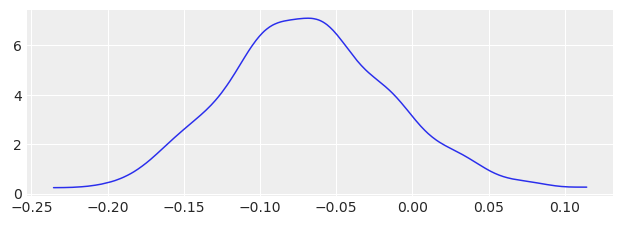

In [17]:
az.plot_trace(idata, kind="rank_vlines");

In [6]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,-0.004,0.045,-0.088,0.079
b,0.990,0.039,0.916,1.061


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

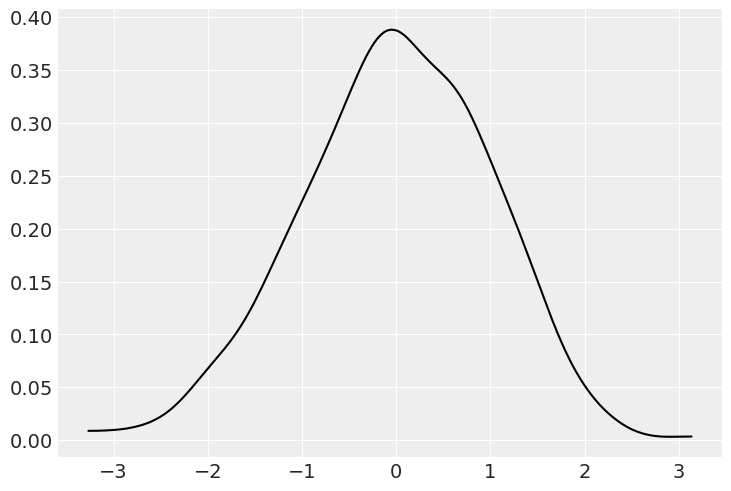

In [7]:
az.plot_ppc(idata, num_pp_samples=500);

In [ ]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1  # one mode with 0.1 of the mass
w2 = 1 - w1  # the other mode with 0.9 of the mass


def two_gaussians(x):
    log_like1 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([pt.log(w1) + log_like1, pt.log(w2) + log_like2])

In [ ]:
with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        initval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    idata_04 = pm.sample_smc(2000)

In [ ]:
az.plot_ppc(idata_04, kind="kde", figsize=(12, 6), textsize=18)

In [ ]:
ax = az.plot_trace(idata_04, compact=True)
ax[0, 0].axvline(-0.5, 0, 0.9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")
f'Estimated w1 = {np.mean(idata_04.posterior["X"] < 0).item():.3f}'

In [ ]:
n = 16

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.1  # one mode with 0.1 of the mass
w2 = 1 - w1  # the other mode with 0.9 of the mass


def two_gaussians(x):
    log_like1 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * pt.log(2 * np.pi)
        - 0.5 * pt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([pt.log(w1) + log_like1, pt.log(w2) + log_like2])

In [ ]:
with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        initval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    idata_16 = pm.sample_smc(2000)
    az_trace_16 = az.from_pymc3(idata_16)

In [ ]:
ax = az.plot_trace(idata_80, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, 0.9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")
# f'Estimated w1 = {np.mean(idata_80.posterior["X"] < 0).item():.3f}'

In [ ]:
az.plot_trace(az_trace_16, compact=True, kind="rank_vlines")